In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nfl_data_py as nfl

## Load data from 2019 to the present
- Data provided by [nfl_data_py](https://pypi.org/project/nfl-data-py/)
- Note that we could have gone back further in time
    - There is no free lunch, however, as extending the analysis window increases the non-stationarity into the data

In [20]:
df = nfl.import_schedules([2019,2020,2021,2022,2023,2024])
df["final_margin"] = df["home_score"] - df["away_score"]

bins = [(0.99, 2.51), (2.99, 3.51), (3.99, 6.51), (6.99, 8.99), (9.01, 99.99)]

## Preprocessing
- Remove pushes
- Remove pick'ems
- Remove games with missing spreads or final scores
- Assign a spread category to each game
    - The key thing is to have a category containing 1.5-2.5 point spreads, and a separate category containing 7.5-9.5 point spreads

In [21]:
# remove pushes
df = df[df["final_margin"]!=df["spread_line"]]

# remove pickems
df = df[df["spread_line"]!=0]

# removes games with missing spreads or final scores
df = df.dropna(subset=["spread_line", "final_margin"])

# assign a spread category to each game
spread_bins = pd.IntervalIndex.from_tuples(bins)
df['spread_bin'] = pd.cut(df['spread_line'].abs(), spread_bins)

### Add required derivative columns
- Add fields for whether the home team, away team, favorite, and underdog win against the spread

In [22]:
df["is_home_win_ats"] = df.apply(lambda x: x["final_margin"] > x["spread_line"], axis=1)
df["is_away_win_ats"] = df.apply(lambda x: x["final_margin"] < x["spread_line"], axis=1)
df["favorite"] = df.apply(lambda x: "home" if x["spread_line"]>0 else "away", axis=1)
df["is_favorite_win_ats"] = df.apply(lambda x: x["is_home_win_ats"] if x["favorite"]=="home" else not x["is_home_win_ats"], axis=1)
df["is_underdog_win_ats"] = df.apply(lambda x: not x["is_home_win_ats"] if x["favorite"]=="home" else x["is_home_win_ats"], axis=1)

### Compute marginal win rates for home, away, favorite, underdog
- We expect these to be below 52.4%, which is the breakeven point for a -110 bet
    - Otherwise, a simple strategy of betting on all home teams, all away teams, all favorites, or all underdogs would be profitable

In [23]:
srs_marginal = df.loc[:,['is_home_win_ats', 'is_away_win_ats', 'is_favorite_win_ats', 'is_underdog_win_ats']].mean()
srs_marginal.name = "marginal win rate"
srs_marginal

is_home_win_ats        0.482376
is_away_win_ats        0.517624
is_favorite_win_ats    0.475849
is_underdog_win_ats    0.524151
Name: marginal win rate, dtype: float64

### As expected, the marginal win rates are near or below 52.4%

### What about if we *condition* the win rates on the identity of the favorite and the magnitude of the spread?

In [24]:
# condition win rates on who the favorite is and the magnitude of the spread
df.groupby(["favorite","spread_bin"])[["is_favorite_win_ats","is_underdog_win_ats"]].mean()

is_favorite_win_ats  is_underdog_win_ats
favorite spread_bin                                             
away     (0.99, 2.51]              0.506098             0.493902
         (2.99, 3.51]              0.523179             0.476821
         (3.99, 6.51]              0.496552             0.503448
         (6.99, 8.99]              0.449275             0.550725
         (9.01, 99.99]             0.406250             0.593750
home     (0.99, 2.51]              0.466321             0.533679
         (2.99, 3.51]              0.465000             0.535000
         (3.99, 6.51]              0.426724             0.573276
         (6.99, 8.99]              0.477941             0.522059
         (9.01, 99.99]             0.520710             0.479290

## Notice that, when conditioning on the favorite and the spread magnitude, some of the win rates are above 52.4%
- For example, betting on a home underdog with a spread above 9 points has a win rate of 58.7% (37 wins, 26 losses ATS)
- More significantly, betting on a home underdog with a spread in the 4-6.5 point range has a win rate of 57.8% (133 wins, 97 losses ATS)

In [25]:
# Uncommment the line below to see the sample size of each group
# df.groupby(["favorite", "spread_bin"])[["is_favorite_win_ats", "is_underdog_win_ats", "is_home_win_ats", "is_away_win_ats"]].count()

## Now let's turn to the primary objective of this blog post: teasers
- First things first, let's review the breakeven percentage for teasers
- There is the breakeven percentage for each leg of the teaser, as well as the breakeven percentage for the teaser as a whole

### For a 6 point teaser at -120, the expected value of the teaser bet is:
$EV = p(\mathrm{win}) \times 100/120 + p(\mathrm{lose}) \times (-1)$ 

$ EV = p(\mathrm{win}) \times 100/120 - (1 - p(\mathrm{win})) $

$ EV = p(\mathrm{win}) \times (1+100/120) - 1 $

$ EV = 0 \rightarrow p(\mathrm{win}) = 1/(1+100/120) \approx 0.5454 $

### In terms of the breakeven percentage for each leg of the teaser, we have:
$p(\mathrm{leg}) = \sqrt{p(\mathrm{win})} = \sqrt{1/(1+100/120)} \approx 0.7385$

### **We need to win 73.92% of the time on each leg of the teaser to break even**

In [26]:
p_win_be = 1/(1+100/120)
p_leg_be = np.sqrt(p_win_be)
print(f"The breakeven percentage for each teaser leg is: {p_leg_be:.4f}")

The breakeven percentage for each teaser leg is: 0.7385


### To analyze teasers, we create an adjusted spread that accounts for the extra points given by the teaser
- It is somewhat complicated that the adjusted line varies depending on whether we are betting on the home or away team
- In the convention here, a positive spread models the home team being favored
    - When betting on the home team, the spread is reduced by the teaser points
    - When betting on the away team, the spread is increased by the teaser points
- For this post, we will focus on 6 point teasers

In [27]:
tease_points = 6
df["teased_spread_line_home"] = df["spread_line"] - tease_points # when betting on home, your spread gets smaller
df["teased_spread_line_away"] = df["spread_line"] + tease_points # when betting on away, your spread gets larger

### Now we can compute the win rates after adjusting for 6 point teasers
- We will compute the win rates for betting on home teams, away teams, favorites, and underdogs

In [28]:
df["is_home_win_ats_teased"] = df.apply(lambda x: x["final_margin"] > x["teased_spread_line_home"], axis=1)
df["is_away_win_ats_teased"] = df.apply(lambda x: x["final_margin"] < x["teased_spread_line_away"], axis=1)
df["is_favorite_win_ats_teased"] = df.apply(lambda x: x["is_home_win_ats_teased"] if x["favorite"]=="home" else x["is_away_win_ats_teased"], axis=1)
df["is_underdog_win_ats_teased"] = df.apply(lambda x: x["is_home_win_ats_teased"] if x["favorite"]=="away" else x["is_away_win_ats_teased"], axis=1)

### Let's display the conditional teaser win rates for home, away, favorite, and underdog
- The key question is whether teasers are indeed only profitable when betting on underdogs in the 1.5-2.5 point range, or favorites in the 7-8.5 point range
### **In other words, is it really true that we need to cross the key numbers of 3, 6, and 7 with each teaser leg?**

In [29]:
dfg = df.groupby(["favorite","spread_bin"])[["is_away_win_ats_teased", "is_home_win_ats_teased"]].mean()

In [30]:
#dfg.columns.rename(["tease away","tease home"], inplace=True)
#dfg

### The findings are somewhat nuanced:
- Teasing a home underdog up from 1.5-2.5 points has a profitable teaser leg win rate of 74.8% (122 wins, 41 losses)
- Teasing an away underdog up from 1.5-2.5 points has a profitable teaser leg win rate of 77.7% (149 wins, 44 losses)

- Teasing a home favorite down from 7-8.5 points is highly unprofitable: 69.4% (93 wins, 41 losses)
- Teasing an away favorite down from 7-8.5 points is profitable: 75% (51 wins, 17 losses)

- Surprisingly, the most profitable teaser condition is teasing an away under up from 4-6.5 points: 77.4% (178 wins, 52 losses)

### 

In [31]:
# To see the sample sizes, uncomment the lines below
dfg_sum = df.groupby(["favorite","spread_bin"])[["is_away_win_ats_teased", "is_home_win_ats_teased"]].sum()
dfg_n = df.groupby(["favorite","spread_bin"])[["is_away_win_ats_teased", "is_home_win_ats_teased"]].count()

print("Sample sizes")
dfg_sum, dfg_n

Sample sizes


(                        is_away_win_ats_teased  is_home_win_ats_teased
 favorite spread_bin                                                   
 away     (0.99, 2.51]                      114                     123
          (2.99, 3.51]                       99                     108
          (3.99, 6.51]                      103                     104
          (6.99, 8.99]                       52                      46
          (9.01, 99.99]                      35                      43
 home     (0.99, 2.51]                      149                     125
          (2.99, 3.51]                      139                     125
          (3.99, 6.51]                      179                     149
          (6.99, 8.99]                       88                      94
          (9.01, 99.99]                     111                     114,
                         is_away_win_ats_teased  is_home_win_ats_teased
 favorite spread_bin                                           

### Visualize the conditional winrates as a color image 

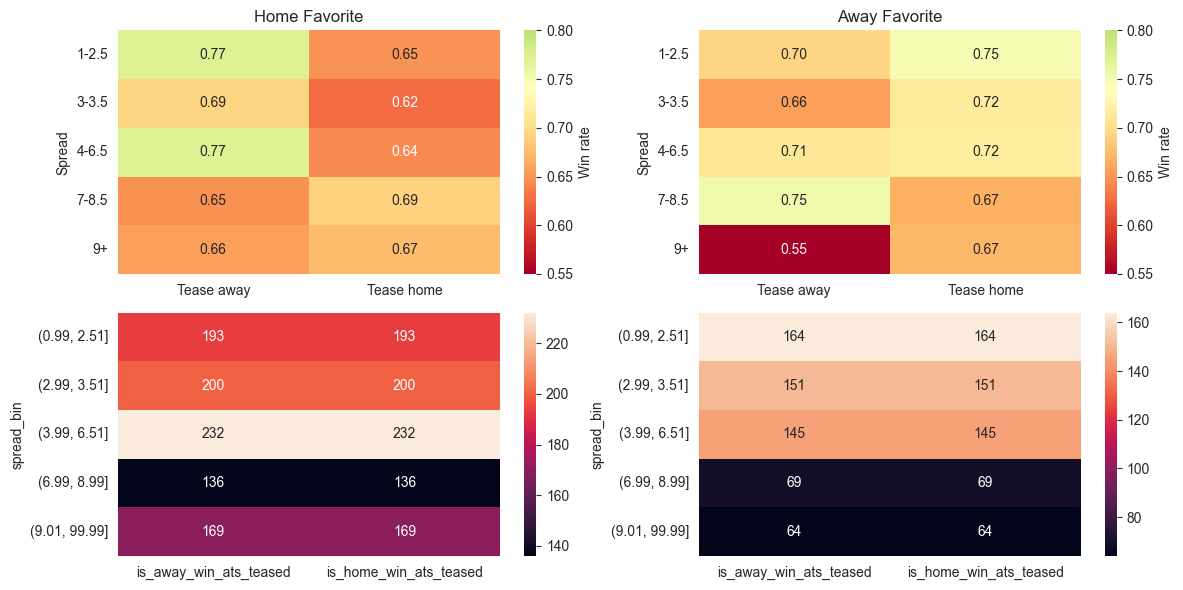

In [60]:
vmin = 0.55
vmax = 0.80
fig, ax = plt.subplots(2,2, figsize=(12,6))
sns.heatmap(dfg.loc["home"], annot=True, fmt=".2f", ax=ax[0,0], center=0.74, cmap="RdYlGn", cbar_kws={'label': 'Win rate'}, vmin=vmin, vmax=vmax)
sns.heatmap(dfg.loc["away"], annot=True, fmt=".2f", ax=ax[0,1], center=0.74, cmap="RdYlGn", cbar_kws={'label': 'Win rate'}, vmin=vmin, vmax=vmax)
ax[0,0].set_title("Home Favorite")
ax[0,1].set_title("Away Favorite")
# change label of column 1 to "tease away"
# change label of column 2 to "tease home"
ax[0,0].set_xticklabels(["Tease away","Tease home"])
ax[0,1].set_xticklabels(["Tease away","Tease home"])
ax[0,0].set_ylabel("Spread")
ax[0,1].set_ylabel("Spread")
ytick_labels = [f"{x.left}-{x.right}" for x in spread_bins]
ytick_labels = ["1-2.5", "3-3.5", "4-6.5", "7-8.5", "9+" ]
ax[0,0].set_yticklabels(ytick_labels)
ax[0,1].set_yticklabels(ytick_labels)


sns.heatmap(dfg_n.loc["home"], annot=True, fmt=".0f", ax=ax[1,0])
sns.heatmap(dfg_n.loc["away"], annot=True, fmt=".0f", ax=ax[1,1])
fig.tight_layout()

plt.show()

fig.savefig("teaser_winrates.png", dpi=300)

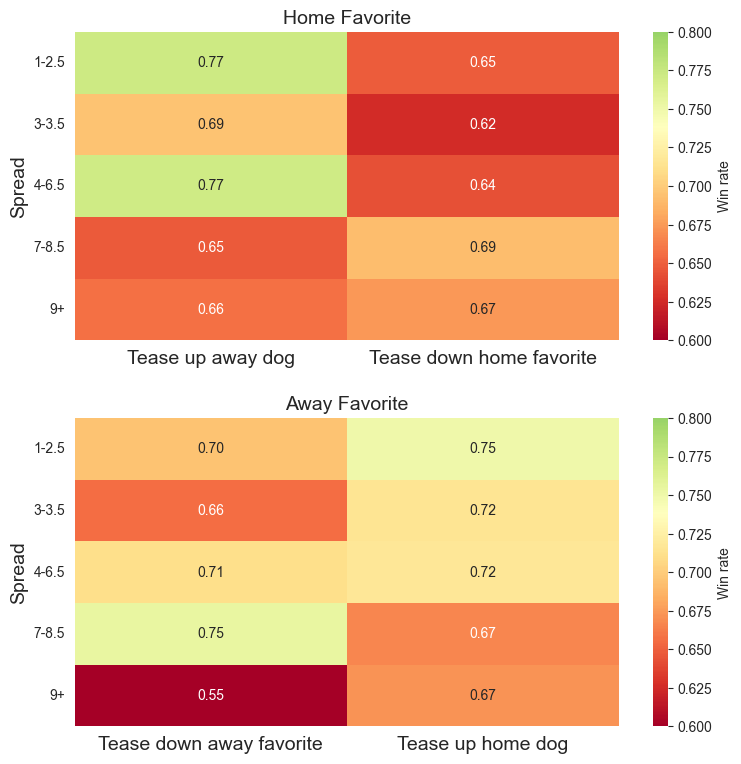

In [63]:
vmin = 0.6
vmax = 0.80
fontdict = {"fontsize": 14}
fig, ax = plt.subplots(2,1, figsize=(8,8))
sns.heatmap(dfg.loc["home"], annot=True, fmt=".2f", ax=ax[0], center=0.7385, cmap="RdYlGn", cbar_kws={'label': 'Win rate'}, vmin=vmin, vmax=vmax)
sns.heatmap(dfg.loc["away"], annot=True, fmt=".2f", ax=ax[1], center=0.7385, cmap="RdYlGn", cbar_kws={'label': 'Win rate'}, vmin=vmin, vmax=vmax)
ax[0].set_title("Home Favorite", fontdict=fontdict)
ax[1].set_title("Away Favorite", fontdict=fontdict)
# change label of column 1 to "tease away"
# change label of column 2 to "tease home"
ax[0].set_xticklabels(["Tease up away dog","Tease down home favorite"], fontdict=fontdict)
ax[1].set_xticklabels(["Tease down away favorite","Tease up home dog"], fontdict=fontdict)
ax[0].set_ylabel("Spread", fontdict=fontdict)
ax[1].set_ylabel("Spread", fontdict=fontdict)
ytick_labels = [f"{x.left}-{x.right}" for x in spread_bins]
ytick_labels = ["1-2.5", "3-3.5", "4-6.5", "7-8.5", "9+" ]
ax[0].set_yticklabels(ytick_labels)
ax[1].set_yticklabels(ytick_labels)

fig.tight_layout(
    pad=2.0
)
fig.savefig("teaser_winrates.png", dpi=300)

## Takeaways

- Consistent with the prevailing view, teasing underdogs up from the 1.5-2.5 range is a profitable strategy
- Consistent with the prevailing view, teasing favorites down from the 7-8.5 range is a profitable strategy but only when the favorite is the away team
- Surprisingly, the most profitable teaser leg is teasing an away underdog up from the 4-6.5 range, perhaps indicating that 10 is an equally key number